# 영화 관객수 예측 경진대회  

참고 url: https://www.dacon.io/competitions/open/235536/overview/description  

## 1. 라이브러리 및 Data set 불러오기

In [7]:
# 현재 디렉토리 우선 확인
import os

print(os.getcwd())

C:\Users\lkm97\Desktop\CUAI 5기


필요한 라이브러리 설치

In [9]:
!pip install lightgbm

In [10]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

필요한 Data set 불러오기

In [11]:
# 데이터 불러오기
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

In [12]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    print('Mac version')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
    print('Linux version')
else:
    print('Unknown system... sorry~~~~')


Windows version


## 2. 탐색적 자료분석
## Exploratory Data Analysis (EDA)
- EDA: 수집한 데이터가 들어왔을 때, 이를 다양한 각도에서 관찰하고 이해하는 과정. 한마디로 데이터를 분석하기 전에 그래프나 통계적인 방법으로 자료를 직관적으로 바라보는 과정을 말함.

+ title : 영화의 제목
+ distributor : 배급사
+ genre : 장르
+ release_time : 개봉일
+ time : 상영시간(분)
+ screening_rat : 상영등급
+ director : 감독이름
+ dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
+ dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
+ num_staff : 스태프수
+ num_actor : 주연배우수
+ box_off_num : 관객수

In [13]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [14]:
movie_best = train.sort_values(ascending = False,by = 'box_off_num').head(10)

In [15]:
movie_best

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
372,국제시장,CJ 엔터테인먼트,드라마,2014-12-17,126,12세 관람가,윤제균,NaN,0,869,4,14262766
362,도둑들,(주)쇼박스,느와르,2012-07-25,135,15세 관람가,최동훈,2.564692e+06,3,462,10,12983841
530,7번방의 선물,(주)NEW,코미디,2013-01-23,127,15세 관람가,이환경,8.190495e+05,2,300,8,12811435
498,암살,(주)쇼박스,액션,2015-07-22,139,15세 관람가,최동훈,5.169479e+06,4,628,3,12706663
460,"광해, 왕이 된 남자",CJ 엔터테인먼트,드라마,2012-09-13,131,15세 관람가,추창민,1.552541e+06,2,402,3,12323595
122,변호인,(주)NEW,드라마,2013-12-18,127,15세 관람가,양우석,NaN,0,311,5,11374879
496,설국열차,CJ 엔터테인먼트,SF,2013-08-01,125,15세 관람가,봉준호,NaN,0,67,10,9350351
101,관상,(주)쇼박스,드라마,2013-09-11,139,15세 관람가,한재림,1.242778e+06,2,298,6,9135806
505,해적: 바다로 간 산적,롯데엔터테인먼트,SF,2014-08-06,130,12세 관람가,이석훈,1.843895e+06,3,868,2,8666208
476,수상한 그녀,CJ 엔터테인먼트,코미디,2014-01-22,124,15세 관람가,황동혁,2.781990e+06,2,437,5,8659725


movie_best: 관객수가 가장 많은 10개 영화들을 출력해줌

<AxesSubplot:xlabel='num_staff', ylabel='box_off_num'>

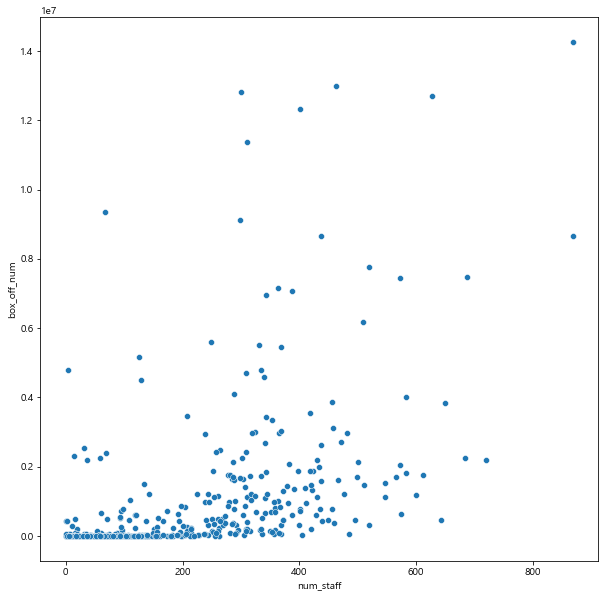

In [16]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='num_staff', y = 'box_off_num')

**<그래프> 스태프수(num_staff)에 대한 관객수(box_off_num)**  
스태프수가 많으면 관객수가 조금 많은 경향이 있음

<AxesSubplot:xlabel='time', ylabel='box_off_num'>

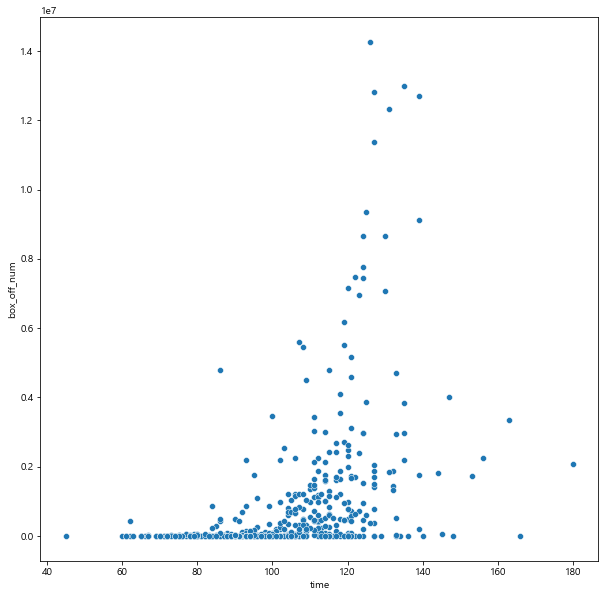

In [17]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='time', y = 'box_off_num')

**<그래프> 상영시간(time)에 대한 관객수(box_off_num)**  
상영시간이 120~140분 사이일 때 관객수가 많은 경향이 있음

<AxesSubplot:xlabel='genre', ylabel='box_off_num'>

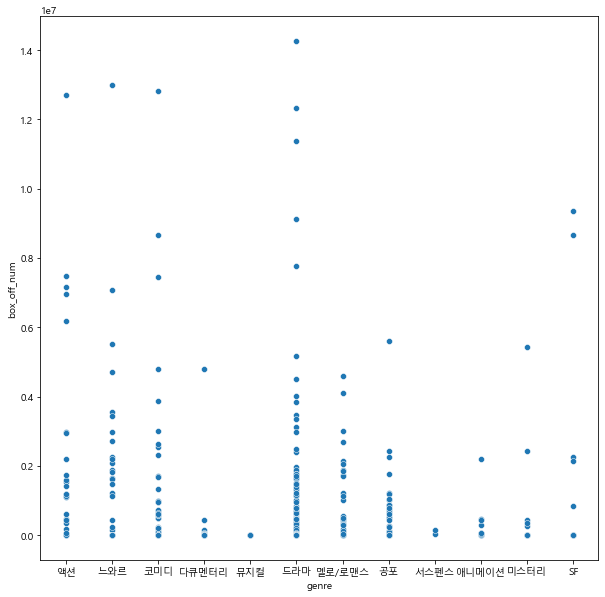

In [18]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='genre', y = 'box_off_num')

**<그래프> 장르(genre)에 대한 관객수(box_off_num)**  
장르가 드라마, 느와르, 코미디, 액션일 때 관객수가 많은 경향이 있음

<AxesSubplot:xlabel='num_actor', ylabel='box_off_num'>

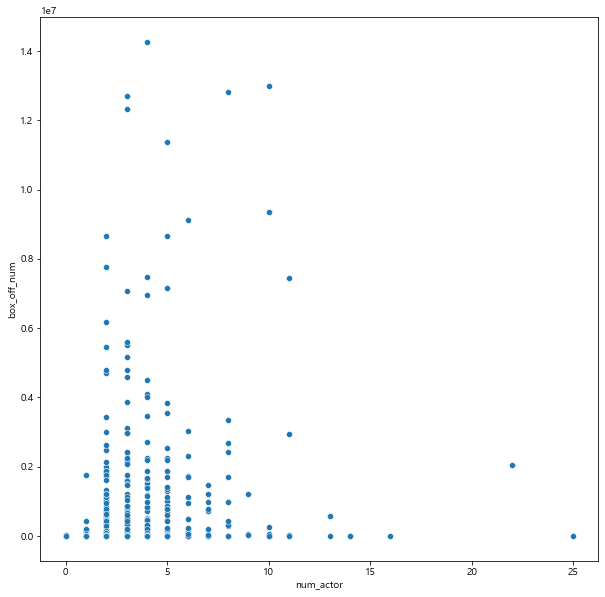

In [19]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='num_actor', y = 'box_off_num')

**<그래프> 주연배우수(num_actor)에 대한 관객수(box_off_num)**  
주연배우가 대부분 2~5명인 영화가 많음을 알 수 있음

**train, test, submission 데이터를 head() 메소드로 확인**  
train 데이터: 모델 학습을 위한 데이터  
test 데이터: 관객수가 없는 데이터  
submission 데이터: 제출을 위한 폼을 제공하는 데이터, test 데이터와 index가 같음

In [20]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [21]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [22]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


**shape 함수: 행의 개수, 열의 개수 확인 가능**

In [23]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


**info 함수: 데이터의 column별 정보(Column), 비어있지 않은 값 개수(Non-Null Count), column의 데이터 타입(Dtype)을 알려줌**  
 - type의 종류 : int(정수), float(실수), object(문자열), 등등 (date, ...)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


위 train 데이터를 보면 dir_prev_dfnum은 270개가 채워져 있고 나머지 330개는 채워지지 않았다는 것을 알 수 있음

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


위 test 데이터도 보면 dir_prev_dfnum은 107개가 채워져 있고 나머지가 채워지지 않았다는 것을 알 수 있음

**hist 함수**로 train 데이터를 히스토그램으로 나타내보면 아래와 같음

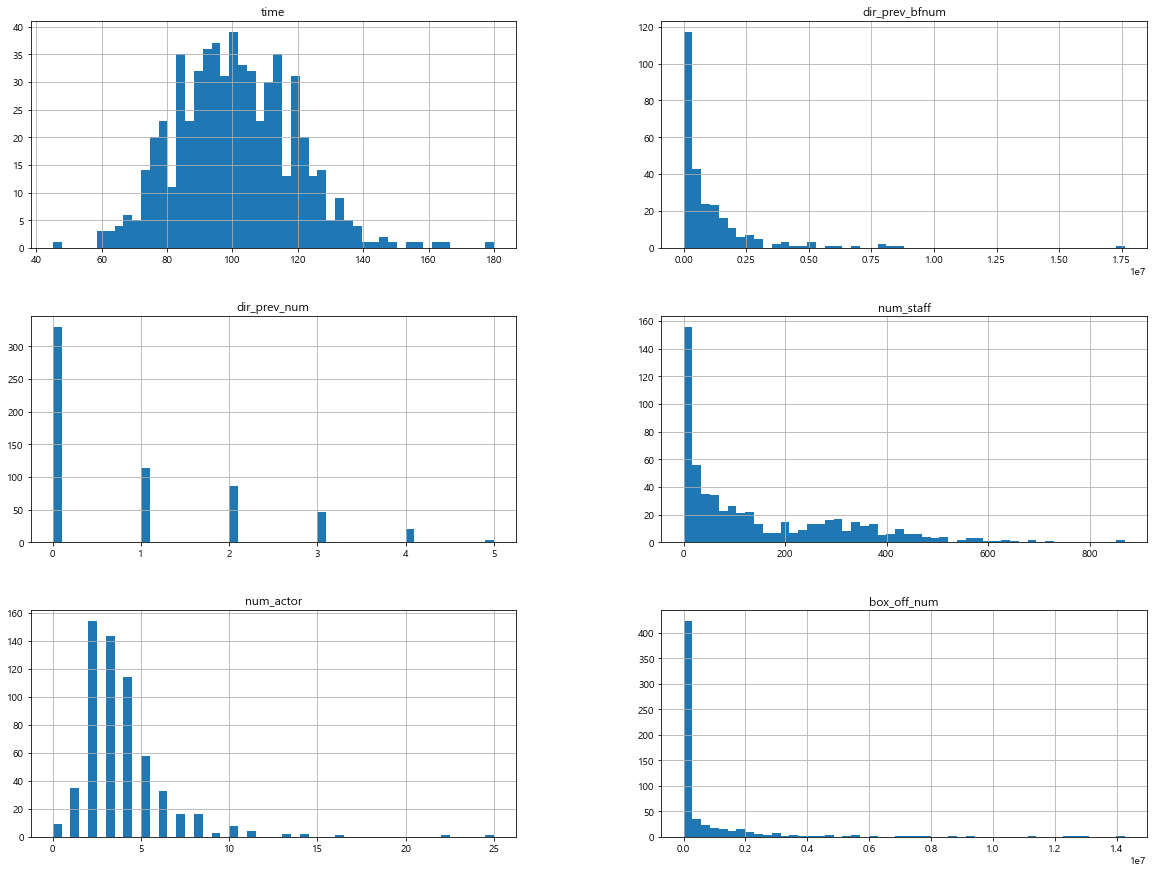

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

train.hist(bins = 50, figsize = (20,15))
plt.show()

**seaborn의 heatmap 함수**로 train 데이터의 column들의 상관관계를 시각화하면 아래와 같음

<AxesSubplot:>

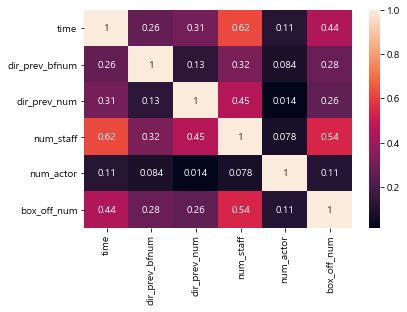

In [27]:
sns.heatmap(train.corr(), annot = True)

## 3. 데이터 전처리
## Data Cleansing & Pre-Processing  

**isna 함수**는 결측치 여부를 확인해줌  
결측치면 True, 아니면 False로 출력됨

In [28]:
train.isna().head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False


**sum 함수**를 이용하면 결측치 개수를 한눈에 쉽게 확인 가능

In [29]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

train 데이터에는 dir_prev_bfnum에 결측치가 330개 있음을 확인할 수 있음

test 데이터의 결측치도 동일하게 확인 가능

In [30]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

test 데이터도 마찬가지로 확인해보면 dir_prev_bfnum에 136개의 결측치가 있음을 확인할 수 있음

**fillna 함수**: 결측치를 채울수 있는 함수  
결측치(NaN)를 0으로 대체, 단 *inplace=True* 설정을 해주어야 NaN이 0으로 바뀐 상태로 저장이 됨

In [31]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [32]:
train['dir_prev_bfnum']

0             NaN
1      1161602.50
2       220775.25
3        23894.00
4            1.00
          ...    
595       3833.00
596     496061.00
597           NaN
598           NaN
599           NaN
Name: dir_prev_bfnum, Length: 600, dtype: float64

In [33]:
train['dir_prev_bfnum'].fillna(0, inplace = True)

In [34]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

결측치 330개가 모두 사라졌음을 확인 가능  
위와 동일하게 test 데이터도 결측치 제거

In [35]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [36]:
test['dir_prev_bfnum'].fillna(0, inplace = True)

In [37]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

## 4. 초기 모델 구축 및 모델 튜닝 수행
## Initial Modeling & Feature Engineering

### Light GBM(LGBM)

In [38]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

random_state=777은 어느 pc에서도 결과값이 같게 나오게 고정시켜줌  
n_estimators은 순차적으로 만드는 모델을 1000번 반복해서 만든다는 뜻

In [39]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

이어서 독립변수(features, X)와 종속변수(target, y)를 생성

In [40]:
X_train, X_test, y_train = train[features], test[features], train[target]

X_train, y_train을 모델에 학습(아래)

In [41]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

submission 데이터를 singleLGBM이라는 변수에 복사한 뒤 예측 진행

In [42]:
singleLGBM = submission.copy()

In [43]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [44]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [45]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,2.817995e+06
1,아빠가 여자를 좋아해,3.753772e+05
2,하모니,-5.693243e+05
3,의형제,1.581189e+06
4,평행 이론,-5.277806e+05


예측이 많이 잘못된 것을 확인할 수 있음(관객수가 음수값이 나올수가 없는데 음수가 나오는것을 확인할 수있음)  
단순 Light GBM 모델은 성능이 별로 안 좋은거 같으므로 다른 모델에 훈련을 진행

### k-fold 교차검증 (k-fold cross validation)

In [46]:
from sklearn.model_selection import KFold

In [47]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=777)

n_splits=5, shuffle=True는 섞어서 5등분을 시킨다는 의미  
섞는 이유는 순서에 대한 영향력이 있을 수 있기에 섞어준다고 생각하면 됨

In [48]:
for train_idx, val_idx in k_fold.split(X_train):
    print(len(train_idx), len(val_idx))
    break

480 120


위 결과를 보면 5등분이 되었다는 것을 알 수 있음  
train_idx은 600개 중 4등분인 480개, val_idx는 120개로 나눠져 있는 것 확인 가능  

In [49]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = [] # 여러 모델을 담을 바구니라 생각하면 됨

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

C:\Users\lkm97\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lkm97\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.70572e+12
[100]	valid_0's l2: 3.90847e+12
[100]	valid_0's l2: 3.50344e+12
[100]	valid_0's l2: 1.45977e+12
[100]	valid_0's l2: 1.77214e+12


early_stopping_rounds=100은 100번의 과정동안 오차율이 감소되지 않으면 멈춰라라는 명령어. 그 이상하면 과적합이 발생하기 때문에 설정해 준 것이라고 생각하면 됨  
위 결과를 보면 [100]은 100번 과정을 다하였다는 뜻

In [50]:
models

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

preds 배열을 만들어서 만들어두었던 모델들의 예측값을 저장해줌

In [51]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [52]:
preds

[array([3367422.08211024,  961138.88337016, 1097929.67851313,
        2097270.81999921,  781476.31131047,  123133.23396977,
          84085.01896248,  199222.92670303,  124854.97973097,
        1072684.78820647,  657040.55769984, 1644701.47160779,
         924735.72080619,  191699.58415836,  723218.39948755,
        2395613.42888462,  113180.54906592, 1882765.92812296,
          97286.47282983,  417270.42113431,  161482.3367577 ,
          63495.73363115,  598057.42337284,  249411.25868881,
         308424.71884273, 1319518.60852241,  202273.52740684,
        1076683.13768137,  491636.41945325,  183406.6380314 ,
        1740233.45816734,   86696.17528125,  440430.29773088,
        2040944.13061099,  113375.45695331,  531746.29484356,
         106207.35971699,  169560.79581187,  158101.0895316 ,
          95037.29701059,  466355.50624629,  197548.63265325,
         198810.0901353 ,  682743.4340129 ,  679265.22397749,
         617812.91125278,  219182.85833837,   83712.10602149,
        

preds를 출력하면 위처럼 예측값들이 5세트가 있는 것을 볼 수 있음

In [53]:
import numpy as np # 5세트의 예측값의 평균을 구하기 위해 numpy를 임포트

In [54]:
kfoldLightGBM = submission.copy() # 답안지 복사

In [55]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0) # mean: 평균값 함수,axis: 축

In [56]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


앞서 singleLGBM 모델과는 달리 관객수를 음수값으로 예측한 것은 없으므로 좀 더 성능이 나아졌다고 판단할 수 있음

### 다음 모델을 사용해보자.

In [57]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor']

**genre**와 **dir_prev_bfnum**를 포함해서 활용해보도록 하자.  
문제는 **genre** 데이터는 아래와 같이 글자로 되어있으니 숫자로 변환하여 사용해야 함

In [58]:
train.genre

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

sklearn에서 제공하는 **labelEncoder**를 활용해서 문자열을 숫자로 변환해보자.

In [59]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder() 
train['genre'] = le.fit_transform(train['genre'])

In [60]:
train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int32

출력 결과 숫자로 잘 변환된 걸 확인할 수 있음  
test set도 동일한 방법으로 변환해주자.

In [61]:
test['genre'] = le.transform(test['genre'])

위 train set에서는 fit_transfirm인데 test set은 transform으로만 변환하였음  
test set에 또 fit(훈련)을 넣어주면 결과값이 틀려질수 있으니 transform만 해야함

In [62]:
test['genre']

0       2
1       5
2       4
3      10
4       1
       ..
238     4
239     3
240     2
241     4
242     5
Name: genre, Length: 243, dtype: int32

test set도 변환된 걸 확인할 수 있음

이제 features에 전처리된 dir_prev_bfnum와 문자열을 숫자로 변환한 genre를 추가해주자.

In [63]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor','dir_prev_bfnum', 'genre']

컬럼이 2개 추가되었으므로 아래와 같이 세팅을 해주면 됨

In [64]:
X_train, X_test, y_train = train[features], test[features], train[target]

genre와 dir_prev_bfnum까지 추가된 데이터로 다시 모델 학습 진행

In [65]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

[100]	valid_0's l2: 2.62067e+12
[100]	valid_0's l2: 4.39227e+12
[100]	valid_0's l2: 3.29841e+12
[100]	valid_0's l2: 1.56499e+12
[100]	valid_0's l2: 1.60118e+12


C:\Users\lkm97\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lkm97\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [66]:
X_test.head()

,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum,genre
0,125,2,304,3,3.005290e+05,2
1,113,4,275,3,3.427002e+05,5
2,115,3,419,7,4.206611e+06,4
3,116,2,408,2,6.913420e+05,10
4,110,1,380,1,3.173800e+04,1


In [67]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

submission 데이터를 feLightGBM이라는 변수에 복사한 뒤 다시 예측 진행

In [68]:
feLightGBM = submission.copy()

In [69]:
feLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [70]:
feLightGBM.head()

,title,box_off_num
0,용서는 없다,3.395493e+06
1,아빠가 여자를 좋아해,8.235439e+05
2,하모니,1.162055e+06
3,의형제,2.184689e+06
4,평행 이론,8.093288e+05


앞서 kfoldLightGBM 모델의 예측 결과와 흡사함을 확인할 수 있음  
좀더 예측 정확도를 높이기 위해 **GridSearchCV로 모델 튜닝 진행**

### Grid Search: 모델 튜닝에 제일 많이 사용

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [74]:
params = {
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples': [20, 30]}

gs = GridSearchCV(estimator=model,
                 param_grid=params,
                  scoring= 'neg_mean_squared_error',
                  cv = k_fold)

params에서 learning_rate는 모델링을 하는 간격으로, 값이 작을수록 점점 더 미세하게 모델의 변화가 이루어진다고 생각하면 됨  

scoring을 'neg_mean_squared_error'로 한 이유는 현재 이 대회의 평가지표가 rmse값이기 때문

만든 모델 gs에 학습을 진행시킴

In [75]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [76]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

gs.best_params_: 6개의 조합중 가장 좋았던 조합을 확인할 수 있음  
가장 좋았던 조합(**learning_rate=0.003, min_child_samples=30**)을 적용하여 모델링 수행

In [77]:
model = lgb.LGBMRegressor(random_state=777,n_estimators=1000, learning_rate=0.003, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose = 100))

C:\Users\lkm97\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\lkm97\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.56673e+12
[200]	valid_0's l2: 2.45583e+12
[300]	valid_0's l2: 2.42575e+12
[400]	valid_0's l2: 2.43392e+12
[100]	valid_0's l2: 4.89194e+12
[200]	valid_0's l2: 4.40922e+12
[300]	valid_0's l2: 4.19146e+12
[400]	valid_0's l2: 4.05951e+12
[500]	valid_0's l2: 3.96931e+12
[600]	valid_0's l2: 3.91727e+12
[700]	valid_0's l2: 3.88462e+12
[800]	valid_0's l2: 3.87695e+12
[900]	valid_0's l2: 3.87088e+12
[100]	valid_0's l2: 3.14361e+12
[200]	valid_0's l2: 2.79286e+12
[300]	valid_0's l2: 2.59302e+12
[400]	valid_0's l2: 2.47608e+12
[500]	valid_0's l2: 2.40386e+12
[600]	valid_0's l2: 2.36407e+12
[700]	valid_0's l2: 2.38505e+12
[100]	valid_0's l2: 1.60592e+12
[200]	valid_0's l2: 1.40227e+12
[300]	valid_0's l2: 1.30053e+12
[400]	valid_0's l2: 1.25184e+12
[500]	valid_0's l2: 1.23543e+12
[600]	valid_0's l2: 1.23595e+12
[100]	valid_0's l2: 1.96107e+12
[200]	valid_0's l2: 1.75478e+12
[300]	valid_0's l2: 1.64513e+12
[400]	valid_0's l2: 1.58132e+12
[500]	valid_0's l2: 1.54801e+12
[600]	va

In [78]:
preds = []

for model in models:
    preds.append(model.predict(X_test))

submission 데이터를 gsLGBM이라는 변수에 복사한 뒤 최종 예측 진행

In [79]:
gsLGBM = submission.copy()

In [80]:
gsLGBM['box_off_num'] = np.mean(preds, axis=0)

In [81]:
gsLGBM.head()

,title,box_off_num
0,용서는 없다,2.974960e+06
1,아빠가 여자를 좋아해,9.823131e+05
2,하모니,1.283210e+06
3,의형제,1.681758e+06
4,평행 이론,9.095845e+05


본 test set에서는 정답값이 주어지지 않아 완벽하게 예측하였는지 확인하긴 어렵지만,  
**이전의 kfoldLightGBM, feLightGBM 모델보다 모델 튜닝을 거친 gsLGBM의 예측값이 훨씬 더 정교하다고 판단할 수 있음**  

gsLGBM 모델의 전체적인 예측값은 아래와 같음

In [82]:
gsLGBM

,title,box_off_num
0,용서는 없다,2.974960e+06
1,아빠가 여자를 좋아해,9.823131e+05
2,하모니,1.283210e+06
3,의형제,1.681758e+06
4,평행 이론,9.095845e+05
...,...,...
238,해에게서 소년에게,7.886130e+04
239,울보 권투부,1.276022e+05
240,어떤살인,4.470473e+05
241,말하지 못한 비밀,2.762433e+05


## END